# Покупка на закрытии и продажа на открытии следующего дня

In [1]:
import pandas as pd
import yfinance as yf
import numpy as np
from tqdm.notebook import tqdm
from numpy_ext import rolling_apply

import matplotlib.pyplot as plt

In [2]:
plt.rcParams['lines.linewidth'] = 3
plt.rcParams['axes.grid'] = True
plt.rcParams['grid.linestyle'] = ':'
plt.rcParams['figure.constrained_layout.use'] = True

## Загрузка данных

In [3]:
start = '1993-01-01'
end = '2020-12-01'
assets = [
    'SPY',
]
df = yf.download(assets, start=start, end=end)

[*********************100%***********************]  1 of 1 completed


In [4]:
#для статистики
stat = pd.DataFrame(columns=[
    'Data',
    'Start_Date',
    'End_Date',
    'Return_On_Account',
    #'Gross_Profit',
    #'Gross_Loss',
    'Num_Of_Trades',
    'Num_Of_Win_Trades',
    'Num_Of_Loss_Trades',
    'Percent_Profitable',
    'Largest_Win_Trade',
    'Largest_Loss_trade',
    'Avg_Win_Trade',
    'Avg_Loss_Trade',
    'Avg_Win_Avg_Loss',
    'Avg_Trade',
    'Max_Cons_Win',
    'Max_Cons_Loss',
    'Max_Drawdown',
    'Profit_Factor',
    'Sharpe_ratio'
])

## Подготовка данных

In [5]:
def add_buy(df):
    """Добавляет сделки
    """
    df['Close_Open_Buy'] = df['Open'].apply(np.log)-df['Close'].shift(1).apply(np.log)
    df['Open_Close_Buy'] = df['Open'].apply(np.log)-df['Close'].apply(np.log)

    df['Close_Open_Sell'] = df['Close'].shift(1).apply(np.log)-df['Open'].apply(np.log)
    df['Open_Close_Sell'] = df['Close'].apply(np.log)-df['Open'].apply(np.log)

    return df

In [6]:
df = add_buy(df)

## Рассчеты

In [8]:
comission = 0.05*2
df['Return_Close_Open_Buy'] = df['Close_Open_Buy'].cumsum().apply(np.exp)
df['Return_Close_Open_Buy_Commiss'] = (df['Close_Open_Buy']-comission/100).cumsum().apply(np.exp)

df['Return_Open_Close_Buy'] = df['Open_Close_Buy'].cumsum().apply(np.exp)
df['Return_Open_Close_Buy_Commiss'] = (df['Open_Close_Buy']-comission/100).cumsum().apply(np.exp)

df['Return_Close_Open_Sell'] = df['Close_Open_Sell'].cumsum().apply(np.exp)
df['Return_Close_Open_Sell_Commiss'] = (df['Close_Open_Sell']-comission/100).cumsum().apply(np.exp)

df['Return_Open_Close_Sell'] = df['Open_Close_Sell'].cumsum().apply(np.exp)
df['Return_Open_Close_Sell_Commiss'] = (df['Open_Close_Sell']-comission/100).cumsum().apply(np.exp)

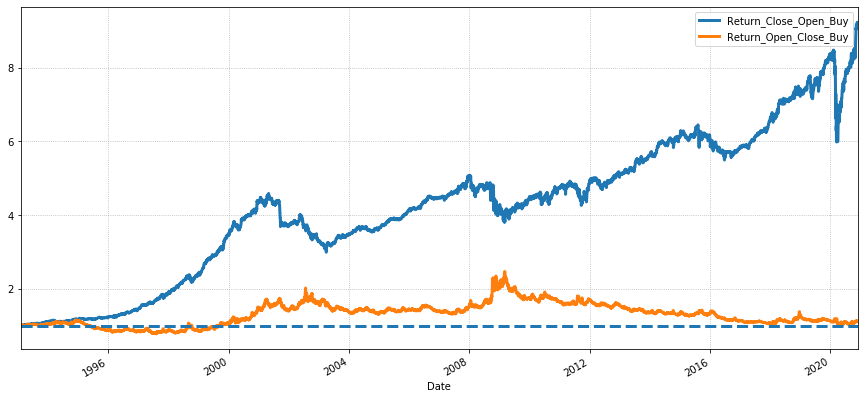

In [18]:
df[[
    'Return_Close_Open_Buy',
    'Return_Open_Close_Buy',
]].plot(figsize=(15,7))
plt.axhline(1,linestyle='--')
#plt.savefig('../src/return_spy_buy.png')

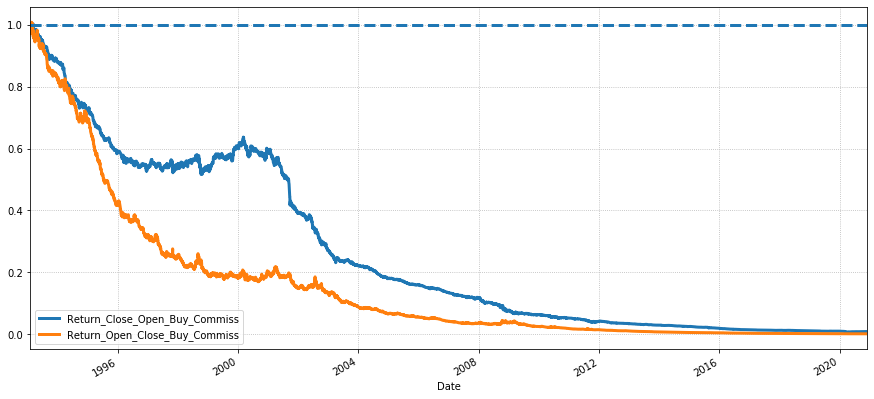

In [19]:
df[[
    'Return_Close_Open_Buy_Commiss',
    'Return_Open_Close_Buy_Commiss',
]].plot(figsize=(15,7))
plt.axhline(1,linestyle='--')
#plt.savefig('../src/return_spy_buy_commiss.png')

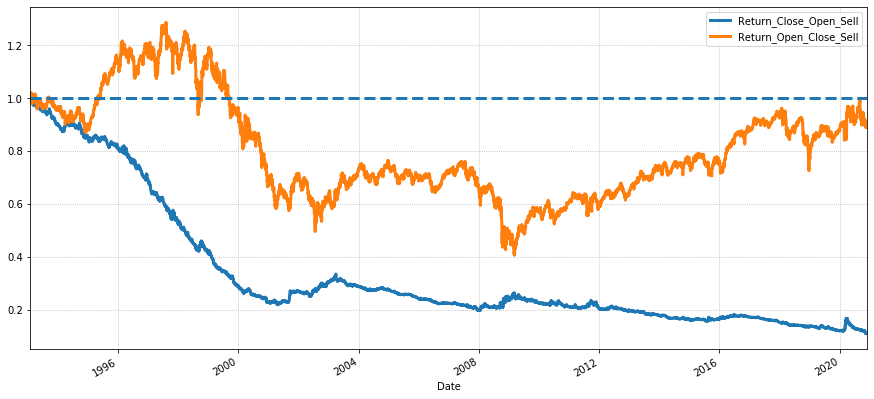

In [20]:
df[[
    'Return_Close_Open_Sell',
    'Return_Open_Close_Sell',
]].plot(figsize=(15,7))
plt.axhline(1,linestyle='--')
#plt.savefig('../src/return_spy_sell.png')

## Статистика

In [13]:
def calc_stat(df_, stat_, trades, ret, data):
    """Cчитает статистику по каждой стратегии

    Определения брал отсюда https://www.investopedia.com/articles/fundamental-analysis/10/strategy-performance-reports.asp
    Args:
	    df_ [dataframe]: массив со сделками
        stat_ [dataframe]: массив со стистикой
        days [int]: максимальное количество дней в в рассчётах
        levers [int]: максимальные рычаг в рассчётах
	Returns:
		[float]: разница в % между текущей и предыдущей ценой при покупке или продаже (или NaN)
    """
    
    start_date = df_[trades].index[0].strftime("%Y-%m-%d")
    end_date = df_[trades].index[-1].strftime("%Y-%m-%d")
    return_on_account = df_[ret].dropna().iloc[-1]
    num_of_trades = df_[ret].dropna().count()
    num_of_win_trades = (df_[trades]>0).sum()
    num_of_loss_trades = (df_[trades]<0).sum()
    percent_profitable = num_of_win_trades/num_of_trades
    largest_win_trade = df_[df_[trades]>0][trades].max()
    largest_loss_trade = df_[df_[trades]<0][trades].min()
    avg_win_trade = df_[df_[trades]>0][trades].mean()
    avg_loss_trade = df_[df_[trades]<0][trades].mean()
    avg_win_avg_loss = abs(avg_win_trade/avg_loss_trade)
    avg_trade = return_on_account/num_of_trades
    
    #max_cons_win https://stackoverflow.com/questions/52717996/how-can-i-count-the-number-of-consecutive-trues-in-a-dataframe
    ge_0 = df_[trades].dropna().ge(0)
    ge_0_cumsum = ge_0.cumsum()
    max_cons_win = ge_0_cumsum.sub(ge_0_cumsum.mask(ge_0).ffill().fillna(0)).astype(int).max()
    
    #max_cons_loss
    le_0 = df_[trades].dropna().le(0)
    le_0_cumsum = le_0.cumsum()
    max_cons_loss = le_0_cumsum.sub(le_0_cumsum.mask(le_0).ffill().fillna(0)).astype(int).max()

    max_drowdown = df_[ret].dropna().div(df_[ret].dropna().cummax()).subtract(1).min()

    #profit_factor
    diff = df_[ret].dropna().diff(1)
    gross_profit = diff[diff.ge(0)].sum()
    gross_loss = abs(diff[diff.le(0)].sum())
    profit_factor = gross_profit/gross_loss

    #https://quant.stackexchange.com/questions/39839/how-to-calculate-sharpe-ratio-from-returns
    sharpe_ratio = (df_[trades].mean()/df_[trades].std())*np.sqrt(252)
    
    #stat_.loc[len(stat_)] = [
    stat_.loc[trades] = [
        data,
        start_date,
        end_date,
        return_on_account,
        num_of_trades,
        num_of_win_trades,
        num_of_loss_trades,
        percent_profitable,
        largest_win_trade,
        largest_loss_trade,
        avg_win_trade,
        avg_loss_trade,
        avg_win_avg_loss,
        avg_trade,
        max_cons_win,
        max_cons_loss,
        max_drowdown,
        profit_factor,
        sharpe_ratio
    ]

    return stat_

In [14]:
stat = calc_stat(df, stat, 'Close_Open_Buy', 'Return_Close_Open_Buy', 'SPY')

In [15]:
stat

,Data,Start_Date,End_Date,Return_On_Account,Num_Of_Trades,Num_Of_Win_Trades,Num_Of_Loss_Trades,Percent_Profitable,Largest_Win_Trade,Largest_Loss_trade,Avg_Win_Trade,Avg_Loss_Trade,Avg_Win_Avg_Loss,Avg_Trade,Max_Cons_Win,Max_Cons_Loss,Max_Drawdown,Profit_Factor,Sharpe_ratio
Close_Open_Buy,SPY,1993-01-29,2020-11-30,9.206414,7010,3834,3021,0.546933,0.058908,-0.110357,0.004106,-0.004476,0.91731,0.001313,17,10,-0.347606,1.136111,0.740326
